In [2]:
!pip install gymnasium
!pip install gymnasium[classic-control]
#!pip install imageio==2.4.1
#!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
#!pip install colabgymrender
#!pip install cv2

  Using cached gymnasium-0.27.1-py3-none-any.whl (883 kB)
  Using cached jax_jumpy-0.2.0-py3-none-any.whl (11 kB)
  Using cached cloudpickle-2.2.1-py3-none-any.whl (25 kB)
  Using cached gymnasium_notices-0.0.1-py3-none-any.whl (2.8 kB)
  Using cached pygame-2.1.3.dev8-cp39-cp39-win_amd64.whl (10.6 MB)


In [1]:
# use "pip install [PACKAGE_NAME]" to get any required packages you don't have

import random
import gymnasium as gym
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout
from keras.optimizers import Adam
from keras import backend as K
import matplotlib.pyplot as plt
import tensorflow as tf

#from colabgymrender.recorder import Recorder # this line is only necessary on google colab

from datetime import datetime

In [2]:
# options: original, plus_velocity, human
reward_type = "original"
episodes = 50

# checks that GPU is being used
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
curr_time = datetime.now()
time_stamp = curr_time.timestamp()
date_time = datetime.fromtimestamp(time_stamp)

date = str(date_time)[0:10]
time = str(date_time)[11:19]

In [4]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.997
        self.learning_rate = 0.002
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(32, input_dim=2))
        model.add(Activation('relu'))

        model.add(Dense(32))
        model.add(Activation('relu'))

        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss="mean_squared_error",
                      optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def update_target_model(self):
        # copy weights from model to target_model
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # returns action

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = self.model.predict(state)
            if done:
                target[0][action] = reward
            else:
                Q_future  = self.target_model.predict(next_state)[0]
                target[0][action] = reward + self.gamma * np.amax(Q_future)
            self.model.fit(state, target, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def save(self, name):
        self.model.save(name)

In [5]:
def get_reward(state, next_state, reward_type):
    if reward_type == "original":
        if next_state[0] >= 0.5:
            print("Car has reached the goal")
            return 10
        if next_state[0] > -0.4:
            return (1+next_state[0])**2
        return 0
    
    elif reward_type == "plus_velocity":
        if next_state[0] >= 0.5:
            print("Car has reached the goal")
            return 10
        # if the next action goes higher or has greater speed, reward
        if next_state[0] > state[0][0] or abs(next_state[1]) > abs(state[0][1]):
            return 1
        else: 
            return 0
    
    elif reward_type == "human":
        if next_state[0] >= 0.5:
            print("Car has reached the goal")
            return 10
        # if slowing down and going higher, reward
        if next_state[0] > state[0][0] and abs(next_state[1]) < abs(state[0][1]):
            return 1
        # if speeding up and going lower, reward
        if next_state[0] < state[0][0] and abs(next_state[1]) > abs(state[0][1]):
            return 1
        else:
            return 0

    else:
        return 0

This was necessary when using colab, but not while using jupyter notebook

if the Recorder breaks above, remove "mode = 'rgb_array'" on lines 20,46

must restart runtime after editing lines, but don't re-run pip lines

In [6]:
env = gym.make('MountainCar-v0', render_mode = "rgb_array") #changed from "rgb_array"
# directory = './MC_videos_{}_{}_{}'.format(reward_type, date, time)
# env = Recorder(env, directory)

np.random.seed(458)

state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)

print('state size:' ,state_size)
print('action size: ', action_size)
done = False
batch_size = 64

state size: 2
action size:  3


In [7]:
scores = 0
step_history = []

for e in range(episodes):
    state = env.reset()[0]
    state = np.reshape(state, [1, state_size])
    flag = 0
    for time in range(200):
        # uncomment this to see the actual rendering 
        #env.render()
        action = agent.act(state)
        next_state, reward, done, info = env.step(action)[0:4]

#         if next_state[1] > state[0][1] and next_state[1]>0 and state[0][1]>0:
#             reward += 15
#         elif next_state[1] < state[0][1] and next_state[1]<=0 and state[0][1]<=0:
#             reward +=15
        
        reward += get_reward(state, next_state, reward_type)


        # give more reward if the cart reaches the flag in 200 steps
#         if done:
#             reward += 100
#         else:
#             # put a penalty if the no of time steps is more
#             reward -= 10  
        next_state = np.reshape(next_state, [1, state_size])
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        scores += reward
        if done:
            flag = 1
            agent.update_target_model()
            print("episode: {}/{}, score: {}, e: {:.2}"
                  .format(e, episodes, scores, agent.epsilon))
            step_history.append(time)
            break

        if len(agent.memory) > batch_size:
            agent.replay(batch_size)
            
    if flag == 0:
        print("episode: {}/{}, score: {}, e: {:.2}".format(e, episodes, time, agent.epsilon)) 
        step_history.append(time)
    if e % (episodes/5) == 0:
        print('saving the model')
        agent.save("./MC_models_{}_{}_{}/mountain_car-dqn_{}.h5".format(reward_type, date, time, e))

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step
episode: 0/50, score: 199, e: 0.66
saving the model
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 20ms/step


KeyboardInterrupt: 

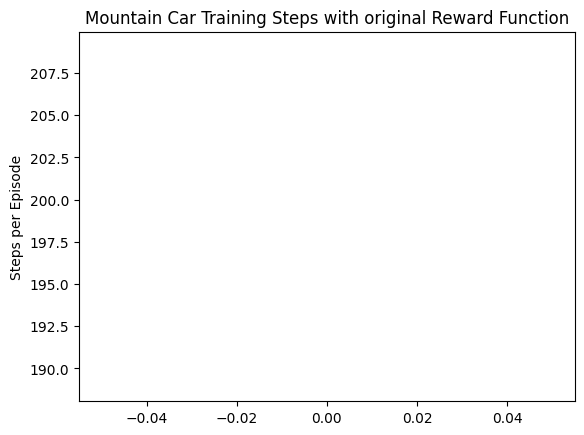

FileNotFoundError: [Errno 2] No such file or directory: './MC_models_original_2023-02-27_3/mountain_car-dqn_image.png'

<Figure size 640x480 with 0 Axes>

In [8]:
colors = {"original" : "blue", "plus_velocity" : "green", "human" : "red"}

plt.plot(step_history, color = colors[reward_type])
plt.ylabel('Steps per Episode')
plt.title("Mountain Car Training Steps with {} Reward Function".format(reward_type))
plt.show()
plt.savefig("./MC_models_{}_{}_{}/mountain_car-dqn_image.png".format(reward_type, date, time, e))